## CAP 6318
### Group 7
### Final Project - Impact of Fast Pass on Attraction Wait Times
#### Dania Alvarez, Melissa Kormesser, & Jillian McIntosh

### Part I. Introduction

Over the years, Disney has revamped its queueing process, transitioning from free paper FastPasses to free digital FastPasses, followed by the paid Genie+ system. Most recently, this evolved into the Lightning Lane system, which includes two options: the Single Pass for one attraction and the Multi Pass, allowing guests to reserve up to three attractions per day. This latest iteration allows guests to enter expedited queues, a service that has become increasingly
monetized. While the precise numbers for the Multi Pass Lightning Lane are not publicly available after the sunset of Genie+, reports indicate that between October 2021 and June 2024, Genie+ generated over 720 million dollars in pretax revenue for The Walt Disney Company(Dammann, 2024).

Additionally, Disney has provided an incentive for guests to stay at Disney properties by allowing them to make Lightning Lane reservations 7 days in advance, compared to just 3 days for off-site guests (Mike, 2024). For example, as of December 2, 2024, the Seven Dwarfs Mine Train Lightning Lane is already sold out until December 8th, with limited availability for the rest of the month (Mike, 2024). While much of the details around the Lightning Lane system are proprietary and dynamic, a rough estimate suggests that the standard ratio of Lightning Lane to regular guests is 4:1, which can spike to 10:1 during peak times (Mike, 2024). During the offseason, it is reasonable to expect a ratio of 2:1. Although Lightning Lane pricing is dynamic, peak season prices can reach up to $450 per person per day (Mike, 2024). Given these changes, one would expect wait times for regular guests to increase due to the priority given to Lightning Lane users. However, Disney fans and sites like Thrill-Data are reporting that wait times have actually decreased, despite steady or at attendance numbers compared to last year (Mike, 2024). So, what is happening with the wait times? Many of the available theories are based on anecdotal observations, including issues around the purchasing of
Lightning Lanes, the uctuating ratio of Lightning Lane to regular guests, and inaccuracies in posted wait times. Currently, there is no solid data to explain this phenomenon (Bricker, 2024).

To address these questions, we propose using Agent-Based Models (ABM) to accurately predict wait times for both Lightning Lane users and regular guests, accounting for different crowd levels and estimating guest satisfaction. We have selected the Seven Dwarfs Mine Train attraction as our model for several reasons: its popularity among both children and adults, its location in the Magic Kingdom (the most popular theme park in the world) (Kelleher, 2024), most of the initial technical issues have been resolved due to its ten years of operations, and that the Lightning Lane for this attraction is available only as a single pass, not as part of a multi-pass package.

Background on Seven Dwarfs Mine Train

The Seven Dwarfs Mine Train, a family-friendly roller coaster, opened on May 28, 2014. Set in the world of Snow White and the Seven Dwarfs, the ride allows guests to board a mine train and follow the dwarves through a mine, ending outside Snow White's cabin (Kubersky, 2022). The attraction operates up to ve trains, each seating 20 guests (Kubersky, 2022). Cast members report that, with technical issues, the minimum dispatch interval is 43 seconds between trains, which results in a throughput of 1,674 guests per hour (Kubersky, 2022).

#### Packages/Libraries

In [1]:
using CSV, DataFrames, Agents, Random, Plots, ShiftedArrays, CairoMakie
using Statistics: mean

### Part II. Agents

The purpose of this code is to simulate guest behavior in a theme park ride scenario. It includes a function `random_initial_priority` that determines whether a guest will be assigned priority access based on a given priority rate. The `new_guests_arrived` function simulates the arrival of new guests in the queue, with a higher arrival rate increasing the likelihood of more guests joining. Additionally, an enumerator `Status` is defined to categorize guest states, such as "Moving", "Waiting", "Riding", or "Finished". Finally, the `Guest` agent struct is defined to represent each guest, storing attributes such as satisfaction, priority status, waiting time, and current status, allowing for dynamic simulation of their behavior during the ride experience. The agents are `GridAgents` and use of the `@agent` macro ensures that they have the proper position and id attributes for use in the model.

In [2]:
include("priority_arrival.jl")

new_guests_arrived (generic function with 1 method)

In [3]:
include("agent_struct.jl")

```julia
@agent struct Guest(GridAgent{2}) <: AbstractAgent
    satisfaction::Float64
    priority::Bool
    waiting_time::Float64
    status::Status  # Moving, Waiting, Riding, or Finished
end
```

In [4]:
include("agent_step.jl")

agent_step! (generic function with 0 methods)

### Part III. Environment

The `crerate_model_environment` script defines a function `setup_ride` that initializes a simulation Agent Based Model for a theme park ride. It sets up a Grid Space environment where guests are placed in a queue based on their priority status, i.e. whether or not they have a fast pass. A grid space was selected as it allowed a ratio of priority/fast pass guests per a set number of regular guests. The model divides guests into groups based on the ride capacity and queue capacity, and assigns each guest a priority status using the `random_initial_priority` function. Guests with priority access are placed at the front of the queue, and their status is set to "Riding" if they are immediately boarding, or "Waiting" if they are in line. The function also includes the setup of various properties such as arrival rate, ride capacity, and the maximum simulation time. The function returns the initalized model, which can later be used to run the simulation.

In [5]:
include("create_model_environment.jl")

setup_ride (generic function with 1 method)

```julia
function setup_ride(n_guests::Int64, ride_capacity::Int64, ride_duration::Float64, queue_capacity::Int64, priority_rate::Float64)
    grid_dims = (ride_capacity,queue_capacity)
    environment = GridSpaceSingle(grid_dims; periodic = false, metric = :manhattan)

    properties = (
        guests = zeros(Int, grid_dims),
        ride_capacity = ride_capacity, 
        queue_capacity = queue_capacity, 
        arrival_rate = 1.0,
        priority_rate = priority_rate,
        ride_duration = ride_duration,
        current_riders_total = 0,
        max_time = 60.0)

    model = ABM(Guest, environment, properties=properties, model_step! = queue_step!)

    #Additional setup of the prioritization
end
```

### Part IV. Model

Steps: <br>
Since our model relies heavily on changes in the environment, we are not making any updates in the agent step method (although we could use it to update their waiting time since this is the only thing that changes on every step).<br>
Our main method is queue_step which runs for the model_step.  Inside this we start moving our guests.  During initialization we setup all guests with position on the first row of the environment (which is a ride_capacity  by queue_capacity grid space) with a 'Riding' status.  In our first step we remove those guests generate new ones and move the current guests based on the types of guests that are generated in each step (priority go to first rows of the environment and regular guests are pushed forward or backwards depending on the number of priority guests added/removed).<br>
For simplicity and to avoid issues we decided to put some boundaries to the number of guests generated each time, so the current functionality generates ride capacity + 2 more guests on every step, depending on the arrival rate. This code is the most important part of our model as it does all the heavy work of moving/updating/generating guests on each step by using all our helper methods:<br>
-   move_and_update_guest! : Updates a guest and moves to a given position
-   move_up! : Calculates the position to move a guest n number of cells up in the queue (closer to the ride)
-   move_down!: Calculates the position to move a guest n number of cells up in the queue (farther from the ride)
-   release_guest!: Removes a guest when the queue capacity has been reached
-   release_riders!: Removes all guests in the front line at the next step after they have reached first row and
    their status has changed to Riding.

In [6]:
include("movement_functions.jl")

organize_priority_guests! (generic function with 1 method)

In [7]:
include("model_step.jl")

queue_step! (generic function with 1 method)

### Part V. Execution

#### Initial Model

The initial model is used as a baseline and does not allow for any guests to have a fast pass.

```julia
n_guests = 1674         # estimated quests per hour
ride_capacity = 20      # Number of guests the ride can handle per ride vehicle
queue_capacity = 2000   # Max number of guests allowed in the queue
ride_duration = .72     # Duration of the ride or 43 seconds per departure of vehicle
priority_rate = 0.0     # No fast passes allowed

model = setup_ride(n_guests, ride_capacity, ride_duration, queue_capacity, priority_rate)
```

Currently there are 0 priority guests in line
Currently there are 1654 regular guests in line
New guests count 21
We have the first scenario
Currently there are 0 priority guests in line
Currently there are 1634 regular guests in line
New guests count 4
We have the first scenario
Currently there are 0 priority guests in line
Currently there are 1614 regular guests in line
New guests count 21
We have the first scenario
Currently there are 0 priority guests in line
Currently there are 1594 regular guests in line
New guests count 16
We have the first scenario
Currently there are 0 priority guests in line
Currently there are 1574 regular guests in line
New guests count 18
We have the first scenario
Currently there are 0 priority guests in line
Currently there are 1554 regular guests in line
New guests count 2
We have the first scenario
Currently there are 0 priority guests in line
Currently there are 1534 regular guests in line
New guests count 3
We have the first scenario
Currently there 

┌ Warning: Keywords `as, am, ac` has been deprecated in favor of
│           `agent_size, agent_marker, agent_color`
└ @ AgentsVisualizations C:\Users\Jillian\.julia\packages\Agents\rX42e\ext\AgentsVisualizations\src\abmplot.jl:70


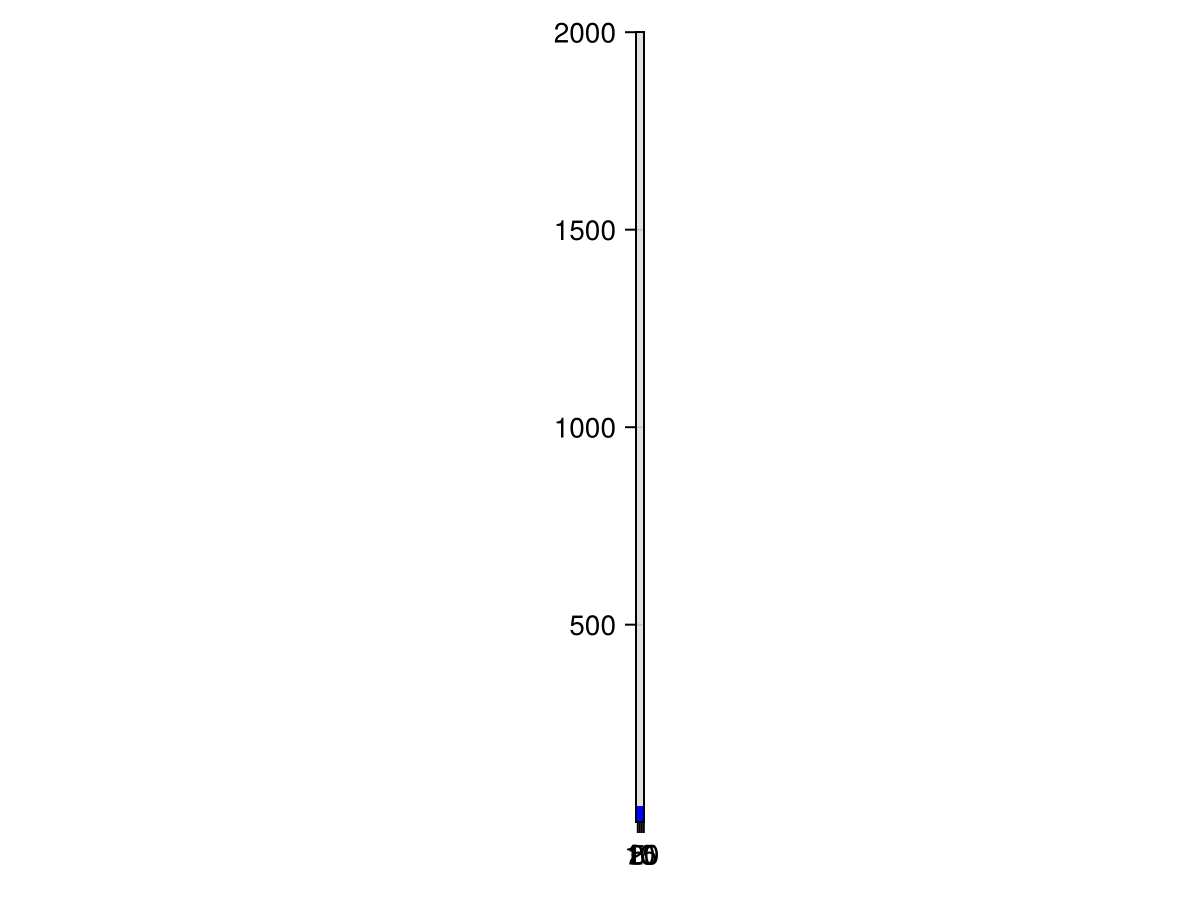

In [8]:
include("no_pass_model.jl")

#### Off Peak with Fast Pass Model

```julia
n_guests = 1674         # estimated quests per hour
ride_capacity = 20      # Number of guests the ride can handle per ride vehicle
queue_capacity = 2000   # Max number of guests allowed in the queue
ride_duration = .72     # Duration of the ride or 43 seconds per departure of vehicle
priority_rate = 0.5     # 2:1 ratio of fast pass to regular queue

model = setup_ride(n_guests, ride_capacity, ride_duration, queue_capacity, priority_rate)
```

In [9]:
include("off_peak_model.jl")

Currently there are 811 priority guests in line
Currently there are 843 regular guests in line
New guests count 2
Currently there are 792 priority guests in line
Currently there are 843 regular guests in line
New guests count 5
Currently there are 776 priority guests in line
Currently there are 843 regular guests in line
New guests count 11
Currently there are 761 priority guests in line
Currently there are 843 regular guests in line
New guests count 19
Currently there are 751 priority guests in line
Currently there are 843 regular guests in line
New guests count 6
Currently there are 732 priority guests in line
Currently there are 843 regular guests in line
New guests count 9
Currently there are 715 priority guests in line
Currently there are 843 regular guests in line
New guests count 13
Currently there are 703 priority guests in line
Currently there are 843 regular guests in line
New guests count 15
Currently there are 684 priority guests in line
Currently there are 843 regular gues

#### Peak with Fast Pass Model

```julia
n_guests = 1674         # estimated quests per hour
ride_capacity = 20      # Number of guests the ride can handle per ride vehicle
queue_capacity = 2000   # Max number of guests allowed in the queue
ride_duration = .72     # Duration of the ride or 43 seconds per departure of vehicle
priority_rate = 0.8     # 4:1 ratio of fast pass to regular queue

model = setup_ride(n_guests, ride_capacity, ride_duration, queue_capacity, priority_rate)
```

In [10]:
include("peak_model.jl")

Currently there are 1331 priority guests in line
Currently there are 323 regular guests in line
New guests count 15
Currently there are 1324 priority guests in line
Currently there are 323 regular guests in line
New guests count 8
Currently there are 1312 priority guests in line
Currently there are 323 regular guests in line
New guests count 10
Currently there are 1301 priority guests in line
Currently there are 323 regular guests in line
New guests count 15
Currently there are 1293 priority guests in line
Currently there are 323 regular guests in line
New guests count 10
Currently there are 1279 priority guests in line
Currently there are 323 regular guests in line
New guests count 20
Currently there are 1276 priority guests in line
Currently there are 323 regular guests in line
New guests count 20
Currently there are 1268 priority guests in line
Currently there are 323 regular guests in line
New guests count 14
Currently there are 1259 priority guests in line
Currently there are 323 

### Part IV. Conclusion

In [11]:
include("plot_results.jl")

visualize_results (generic function with 1 method)

Descriptive Statistics for Waiting Time:
Mean Waiting Time: 24.227188081936685
Median Waiting Time: 22.0
Standard Deviation of Waiting Time: 16.633666636097338
Minimum Waiting Time: 0.0
Maximum Waiting Time: 60.0
Quantiles (25%, 50%, 75%): [10.0, 22.0, 37.0]

Average Overall Satisfaction: 75.77281191806331


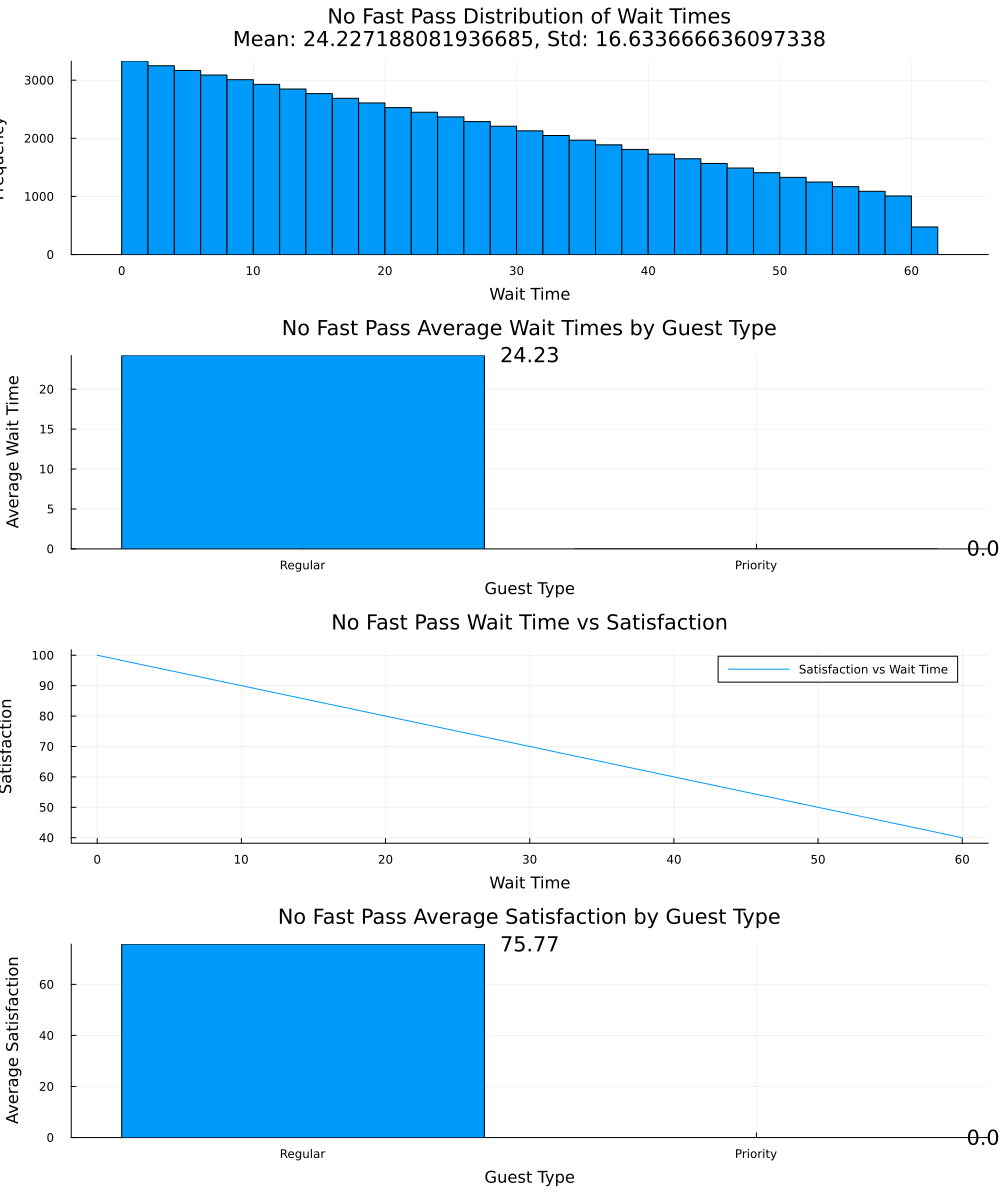

In [12]:
visualize_results(m1_adf, "No Fast Pass")

Descriptive Statistics for Waiting Time:
Mean Waiting Time: 24.78476213605332
Median Waiting Time: 22.0
Standard Deviation of Waiting Time: 17.32167155135069
Minimum Waiting Time: 0.0
Maximum Waiting Time: 60.0
Quantiles (25%, 50%, 75%): [10.0, 22.0, 38.0]

Average Overall Satisfaction: 75.21523786394668


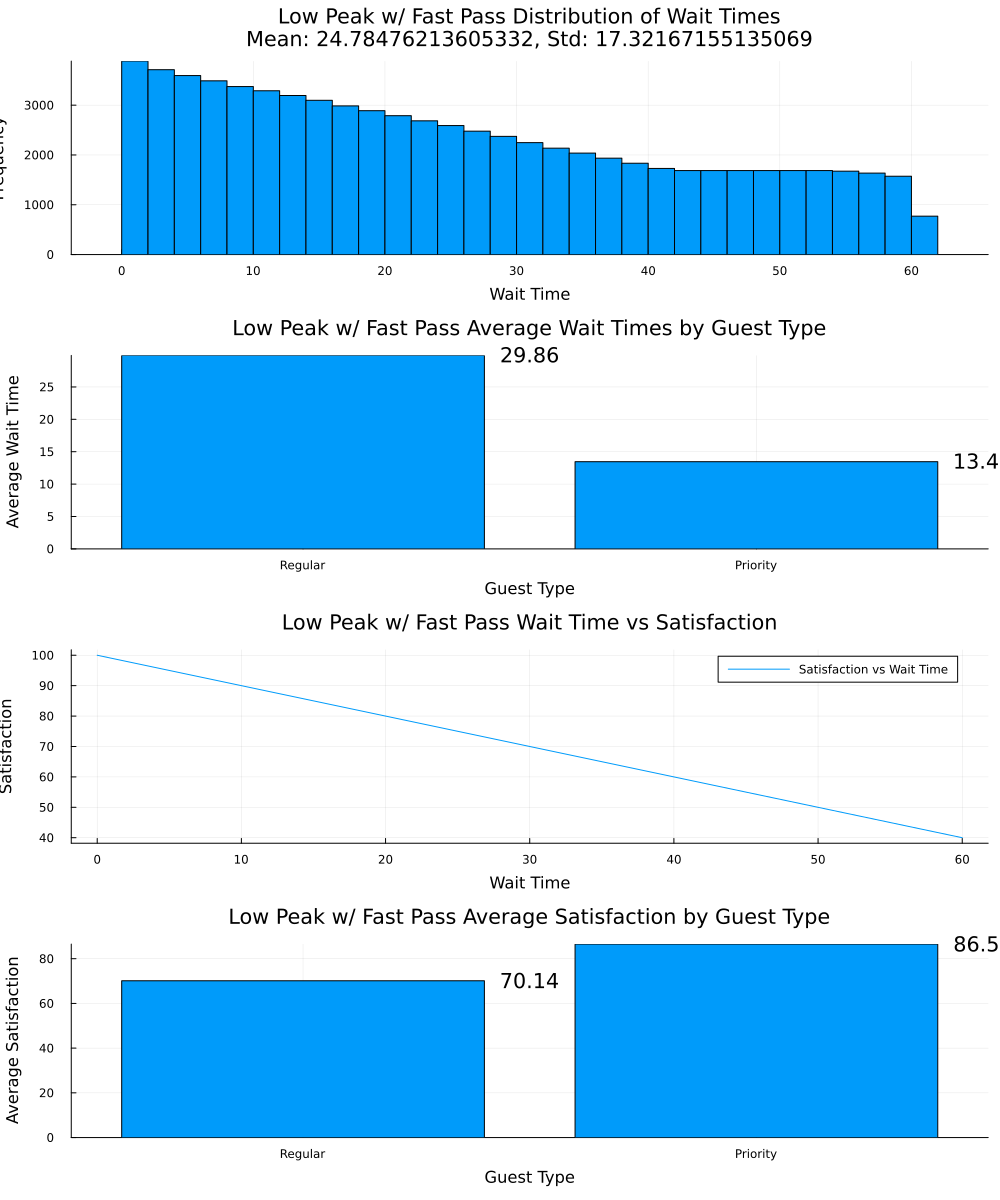

In [13]:
visualize_results(m2_adf, "Low Peak w/ Fast Pass")

Descriptive Statistics for Waiting Time:
Mean Waiting Time: 23.184055845603332
Median Waiting Time: 21.0
Standard Deviation of Waiting Time: 16.205595671366922
Minimum Waiting Time: 0.0
Maximum Waiting Time: 60.0
Quantiles (25%, 50%, 75%): [9.0, 21.0, 35.0]

Average Overall Satisfaction: 76.81594415439668


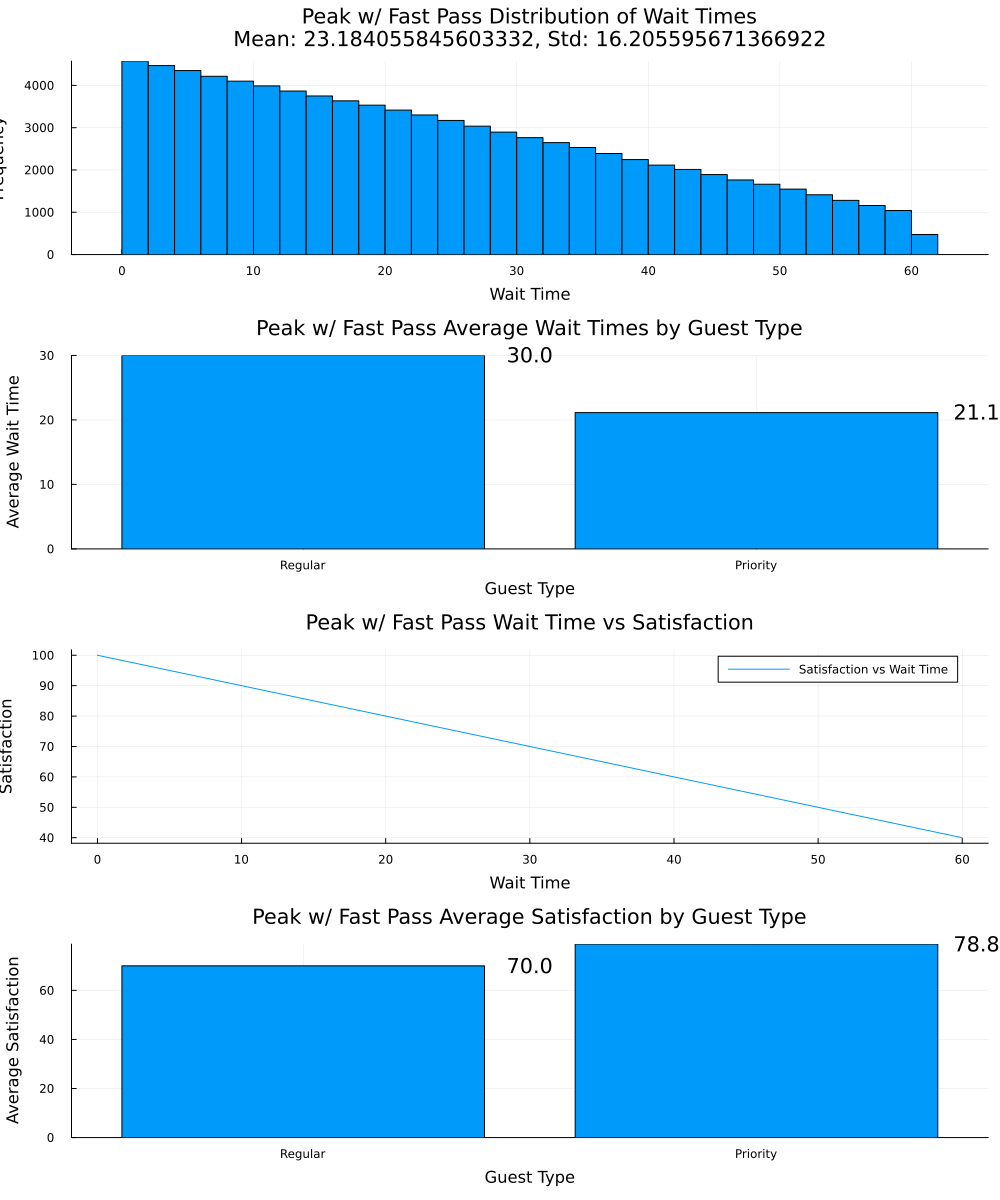

In [14]:
visualize_results(m3_adf, "Peak w/ Fast Pass")

In our simulation of the Three Models for Seven Dwarves Mine Train, we simulated up to 2000 guests within a single hour, considering the ride's hourly capacity of 1674 guests. The three scenarios for Fast Pass utilization were examined:

- No Fast Pass: Guests waited in a single queue, leading to an average satisfaction of 75% and an average wait time of 24.2 time steps.
- Low Peak, 2:1 Fast Pass Ratio: A scenario with a lower number of Fast Pass users, resulting in an average satisfaction of 75.3% and an average wait time of 24.6 time steps.
- High Peak, 4:1 Fast Pass Ratio: A higher proportion of Fast Pass users, with an average satisfaction of 76.7% and an average wait time of 23.2 time steps.

<b> Key Insights: </b> <br>
- Satisfaction and Wait Times: While overall satisfaction remained relatively consistent across the three models, with a slight increase in satisfaction for the High Peak, 4:1 Fast Pass ratio, the wait times varied minimally. Despite the higher proportion of Fast Pass users in the High Peak scenario, the wait time decreased slightly, which could indicate some level of efficiency gained through the priority access system. However, the satisfaction remained nearly unchanged, suggesting that the Fast Pass system does not drastically improve the overall experience for most guests.

- Impact on Guest Consistency: A more important observation was the growing disparity between the experiences of Fast Pass users and regular guests. As the number of Fast Pass users increased, regular guests faced longer wait times, leading to less consistent experiences across all guests. This highlights a key trade-off in Fast Pass systems: while a smaller group of guests may benefit from faster access, those without Fast Passes face worse experiences.

- Diminishing Returns for Fast Pass Users: Interestingly, as the proportion of Fast Pass users grew, the diminishing return for their wait times became apparent. In the High Peak scenario, Fast Pass users enjoyed slightly shorter wait times, but the difference was marginal. This suggests that a 4:1 ratio of Fast Pass users may not yield significant improvements in wait times for those using the system, as the increased number of priority users creates congestion and limits the benefits for all.

<b> Limitations and Future Model Extensions:</b> <br>
This analysis, while insightful, is quite rudimentary for several reasons:

- Single Ride Simulation: The model considers only a single ride, Seven Dwarves Mine Train, out of an entire park. In reality, theme parks have multiple rides and attractions, each with different wait times and guest preferences. Extending the model to multiple rides would create a more comprehensive simulation of park operations.

- Lack of Guest Preferences: Currently, the model does not account for the likelihood that guests might choose to join the queue or opt for other activities based on estimated wait times. Real-world park operations involve guest preferences, which impact how visitors interact with the system. For instance, guests may decide not to wait in long lines even if they are offered a Fast Pass, and their preferences can vary depending on factors like the ride's popularity, the time of day, or personal schedules.

- Guest Removal Due to Priority System: Another shortcoming of the current simulation is that a guest could be removed from the line if too many priority Fast Pass holders join the queue. This scenario does not accurately reflect how the real Fast Pass system works, where priority access doesn't typically result in the removal of regular guests. In reality, Fast Pass users may experience shorter waits, but they don't completely eliminate regular guests from the queue.

- Need for More Realistic Agents: The model could be improved by incorporating more realistic agents that simulate guest behavior and preferences. By capturing factors such as likelihood to purchase a Fast Pass, guests' expectations regarding wait times, and how they respond to varying levels of congestion, the simulation could offer more accurate insights into how Fast Pass systems affect both guest satisfaction and operational efficiency.

- Park-Wide Demand Simulation: To create a more realistic and useful model, it would be beneficial to extend the simulation to simulate park-wide demand, where guests can select different rides at different times of day. This would allow the model to capture not just the experience of a single ride, but also how the flow of guests impacts the park as a whole. The addition of multiple environments (rides) could simulate park capacity limits, ride popularity at different times, and the overall guest distribution.

<b> Potential Applications for Park Operations:</b> <br>
By extending the model to account for realistic guest preferences, ride demand, and park-wide dynamics, the simulation could provide valuable insights for various aspects of theme park operations:

- Pricing Decisions for Fast Passes: By modeling guest demand for Fast Passes and their willingness to pay for quicker access, parks could optimize pricing strategies. For instance, dynamic pricing based on ride popularity and park congestion could help maximize revenue without overloading the system.

- Staffing Needs: Understanding guest flow across different rides could inform staffing decisions, ensuring that each area of the park is adequately staffed to handle peak demand and minimize wait times.

- Park Reservation Limits: The model could also help park operators set more effective reservation limits and manage crowd sizes. By simulating how many guests can be effectively accommodated with Fast Passes and regular tickets, parks can better control attendance and improve overall guest satisfaction.

- Ticket Limitations: Finally, simulating different ticketing scenarios, such as limiting the number of regular tickets or increasing Fast Pass availability during peak times, could allow parks to better manage their capacity and ensure a more enjoyable experience for all guests.

<b> Conclusion:</b> <br>
This analysis highlights the trade-offs and potential inefficiencies of Fast Pass systems in theme parks. While Fast Passes can provide some benefits to those willing to pay for quicker access, they also create disparities in the guest experience. Further development of the model, including realistic guest behavior and park-wide simulations, could provide more accurate insights and help theme parks make data-driven decisions for optimizing operations, pricing, staffing, and overall guest satisfaction.

### Part IIV. References

<div style="margin-left: 20px; text-indent: -20px;">
    Bricker, T. (2024, December 2). <i>Shorter standby lines and lightning lanes at Disney World?!</i> Disney Tourist Blog.  
    <a href="https://www.disneytouristblog.com/shorter-standby-lightning-lanesdisney-world/">https://www.disneytouristblog.com/shorter-standby-lightning-lanesdisney-world/</a>
</div>
<br>
<div style="margin-left: 20px; text-indent: -20px;">
    Dammann, L. (2024, September 6). <i>The shocking amount of money Disney made off its genie+ line-skipping tool.</i> Inside the Magic.  
    <a href="https://insidethemagic.net/2024/09/the-shockingamount-of-money-disney-made-off-its-genie-line-skipping-tool-ld1/">https://insidethemagic.net/2024/09/the-shockingamount-of-money-disney-made-off-its-genie-line-skipping-tool-ld1/</a>
</div>
<br>
<div style="margin-left: 20px; text-indent: -20px;">
    Kelleher, S. R. (2024, August 19). <i>How Disney dominated the global theme park industry in 2023.</i> Forbes.  
    <a href="https://www.forbes.com/sites/suzannerowankelleher/2024/08/16/howdisney-dominated-the-theme-park-industry-in-2023/">https://www.forbes.com/sites/suzannerowankelleher/2024/08/16/howdisney-dominated-the-theme-park-industry-in-2023/</a>
</div>
<br>
<div style="margin-left: 20px; text-indent: -20px;">
    Kubersky, S. (2022, September 16). <i>Seven dwarfs mine train opening day observations.</i> TouringPlans.com Blog.  
    <a href="https://touringplans.com/blog/seven-dwarfs-mine-train-openingday-observations/">https://touringplans.com/blog/seven-dwarfs-mine-train-openingday-observations/</a>
</div>
<br>
<div style="margin-left: 20px; text-indent: -20px;">
    Mike. (2024, December 2). <i>Walt Disney World Lightning lane pass trends heading into the busy holiday season.</i> BlogMickey.com - Disney World News, Photos, and Info.  
    <a href="https://blogmickey.com/2024/12/walt-disney-world-lightning-lane-trends-holiday-season/">https://blogmickey.com/2024/12/walt-disney-world-lightning-lane-trends-holiday-season/</a>
</div>